# Simulation of production line with defects - Training Via Configuration File

In this notebook we will train a Anomalib model using the Anomalib API and our own dataset. This notebook is also part of the Dobot series notebooks.

### Use case

Using the [Dobot Magician](https://www.dobot.cc/dobot-magician/product-overview.html) we could simulate a production line system. Imagine we have a cubes factory and they need to know when a defect piece appear in the process. We know very well what is the aspecto of the normal cubes. Defects are coming no often and we need to put those defect cubes out of the production line.

<img src="https://user-images.githubusercontent.com/10940214/174126337-b344bbdc-6343-4d85-93e8-0cb1bf39a4e3.png" alt="drawing" style="width:400px;"/>


| Class | Yellow cube | Red cube | Green cube | Inferencing using Anomalib
| --------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | --------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| Normal | <img src="https://user-images.githubusercontent.com/10940214/174083561-38eec918-efc2-4ceb-99b1-bbb4c91396b2.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083638-85ff889c-6222-4428-9c7d-9ad62bd15afe.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083707-364177d4-373b-4891-96ce-3e5ea923e440.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129305-03d9b71c-dfd9-492f-b42e-01c5c24171cc.jpg" alt="drawing" style="width:150px;"/> |
| Abnormal | <img src="https://user-images.githubusercontent.com/10940214/174083805-df0a0b03-58c7-4ba8-af50-fd94d3a13e58.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083873-22699523-22b4-4a55-a3da-6520095af8af.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083944-38d5a6f4-f647-455b-ba4e-69482dfa3562.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129253-f7a567d0-84f7-4050-8065-f00ba8bb973d.jpg" alt="drawing" style="width:150px;"/> | 

Using Anomalib we are expecting to see this result.

### Set up the working directory

In [1]:
from __future__ import annotations

import os
from pathlib import Path

from git.repo import Repo
from matplotlib import pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from anomalib.config import get_configurable_parameters
from anomalib.data.folder import Folder
from anomalib.data.task_type import TaskType
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import Padim
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    PostProcessingConfigurationCallback,
)
from anomalib.utils.callbacks.export import ExportCallback, ExportMode

current_directory = Path.cwd()
if current_directory.parent.name == "500_use_cases" and current_directory.name == "501_Dobot":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/500_use_cases/501_Dobot
    root_directory = current_directory.parent.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)
notebook_path = root_directory / "notebooks" / "500_use_cases" / "501_Dobot"
dataset_path = root_directory / "datasets" / "cubes"

## Imports

## Configuration - Via API

Using the API we will setup different Anomalib modules, data manager, model manager, experiment manager and callback manager. We can modify the setup modifying the configuration file and also API.

## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

In [3]:
MODEL = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = notebook_path / "cubes_config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

# Replace the dataset configs with the following.
dataset:
  name: cubes
  format: folder
  path: /datasets/cubes
  normal_dir: normal # name of the folder containing normal images.
  abnormal_dir: abnormal # name of the folder containing abnormal images.
  task: classification # classification or segmentation
  mask: null
  extension: null
  seed: 0
  normal_test_dir: null # optional
  extensions: null
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: null # dimensions to which images are center-cropped after resizing (optional)
  normalization: none # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_t

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/development/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/cubes` as the path to the dataset. We need to overwrite this after loading the config.

Now, the config file is updated as we want. We can now start model training with it. Here we will be using datamodule, model and callbacks to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In addition to the training, we would like to perform inference using OpenVINO. Therefore we will set the export configuration to openvino so that anomalib would export the trained model to the openvino format.

In [4]:
# pass the config file to model, logger, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
config["dataset"]["path"] = str(dataset_path)  # or wherever the Custom Dataset is stored.
print(config)

{'dataset': {'name': 'cubes', 'format': 'folder', 'path': '/home/ashwin/projects/anomalib/datasets/cubes', 'normal_dir': 'normal', 'abnormal_dir': 'abnormal', 'task': 'classification', 'mask': None, 'extension': None, 'seed': 0, 'normal_test_dir': None, 'extensions': None, 'train_batch_size': 32, 'eval_batch_size': 32, 'num_workers': 8, 'image_size': [256, 256], 'center_crop': None, 'normalization': 'none', 'transform_config': {'train': None, 'eval': None}, 'test_split_mode': 'from_dir', 'test_split_ratio': 0.2, 'val_split_mode': 'same_as_test', 'val_split_ratio': 0.5, 'tiling': {'apply': False, 'tile_size': None, 'stride': None, 'remove_border_count': 0, 'use_random_tiling': False, 'random_tile_count': 16}, 'mask_dir': None, 'root': '/datasets/cubes'}, 'model': {'name': 'padim', 'backbone': 'resnet18', 'pre_trained': True, 'layers': ['layer1', 'layer2', 'layer3'], 'normalization_method': 'min_max', 'input_size': [256, 256]}, 'metrics': {'image': ['F1Score', 'AUROC'], 'pixel': ['F1Scor

/home/ashwin/projects/anomalib/anomalib/config/config.py:253: DeprecationWarning: mask will be deprecated in favor of mask_dir in config.dataset in a future release.
  warn(
/home/ashwin/projects/anomalib/anomalib/config/config.py:260: DeprecationWarning: path will be deprecated in favor of root in config.dataset in a future release.
  warn(DeprecationWarning("path will be deprecated in favor of root in config.dataset in a future release."))
/home/ashwin/projects/anomalib/anomalib/config/config.py:275: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


### Dataset: Cubes

Prepare your own dataset for normal and defect pieces.

In [5]:
datamodule = Folder(
    root=dataset_path,
    normal_dir="normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.2,
    image_size=(256, 256),
    train_batch_size=32,
    eval_batch_size=32,
    task=TaskType.CLASSIFICATION,
)
datamodule.setup()  # Split the data to train/val/test/prediction sets.
datamodule.prepare_data()  # Create train/val/test/predic dataloaders

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image'])


In [6]:
# Check image size
print(data["image"].shape)

torch.Size([32, 3, 256, 256])


### Prepare the Model 
We will use Padim model for this use case, which could imported from `anomalib.models`.

In [7]:
model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

/home/ashwin/miniconda3/envs/project_anomalib/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
/home/ashwin/miniconda3/envs/project_anomalib/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtr

## Prepare Callbacks

To train the model properly, we will to add some other "non-essential" logic such as saving the weights, early-stopping, normalizing the anomaly scores and visualizing the input/output images. To achieve these we use `Callbacks`. Anomalib has its own callbacks and also supports PyTorch Lightning's native callbacks. So, let's create the list of callbacks we want to execute during the training.

In [8]:
callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC"],
    ),
    ModelCheckpoint(
        mode="max",
        monitor="image_AUROC",
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),
    ExportCallback(
        input_size=(256, 256),
        dirpath=str(notebook_path),
        filename="model",
        export_mode=ExportMode.OPENVINO,
    ),
]

To use wandb logger install it using `pip install wandb`


## Training

Now that we set up the datamodule, model and the callbacks, we could now train the model.

The final component to train the model is `pytorch_lightning` `Trainer` object, which handles train/test/predict pipeline. Let's create the trainer object to train the model.

In [9]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",
    auto_scale_batch_size=False,
    check_val_every_n_epoch=1,
    devices=1,
    gpus=None,
    max_epochs=1,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ashwin/miniconda3/envs/project_anomalib/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_pr

Epoch 0:  60%|██████    | 3/5 [00:02<00:01,  1.37it/s, loss=nan, v_num=6]

/home/ashwin/miniconda3/envs/project_anomalib/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Epoch 0: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it, loss=nan, v_num=6, image_AUROC=1.000]

/home/ashwin/miniconda3/envs/project_anomalib/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: `torchmetrics.functional.auc` has been move to `torchmetrics.utilities.compute` in v0.10 and will be removed in v0.11.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=1` reached.
/home/ashwin/.local/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/ashwin/.local/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered intern

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/ashwin/projects/anomalib/notebooks/500_use_cases/501_Dobot/openvino/model.onnx
	- Path for generated IR: 	/home/ashwin/projects/anomalib/notebooks/500_use_cases/501_Dobot/openvino
	- IR output name: 	model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Front

In [10]:
# Validation
test_results = trainer.test(model=model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ashwin/miniconda3/envs/project_anomalib/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
/home/ashwin/m

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC                  1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/ashwin/miniconda3/envs/project_anomalib/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: `torchmetrics.functional.auc` has been move to `torchmetrics.utilities.compute` in v0.10 and will be removed in v0.11.
  warnings.warn(*args, **kwargs)


## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

### Load a Test Image
Let's read an image from the test set and perform inference using OpenVINO inferencer.

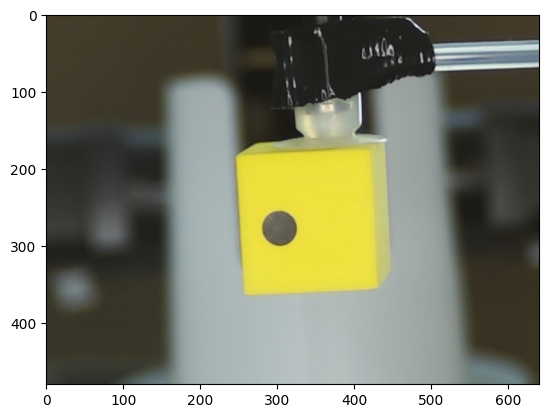

In [11]:
image_path = root_directory / "datasets/cubes/abnormal/input_20230210134059.jpg"
image = read_image(path="datasets/cubes/abnormal/input_20230210134059.jpg")
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.

In [12]:
openvino_model_path = notebook_path / "openvino" / "model.bin"
metadata_path = notebook_path / "openvino" / "meta_data.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [14]:
inferencer = OpenVINOInferencer(
    config=CONFIG_PATH,  # Pass the config file to the inferencer.
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    meta_data_path=metadata_path,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

/home/ashwin/projects/anomalib/anomalib/config/config.py:253: DeprecationWarning: mask will be deprecated in favor of mask_dir in config.dataset in a future release.
  warn(
/home/ashwin/projects/anomalib/anomalib/config/config.py:260: DeprecationWarning: path will be deprecated in favor of root in config.dataset in a future release.
  warn(DeprecationWarning("path will be deprecated in favor of root in config.dataset in a future release."))
/home/ashwin/projects/anomalib/anomalib/config/config.py:275: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


### Perform Inference
Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.

In [15]:
print(image.shape)
predictions = inferencer.predict(image=image)

(480, 640, 3)


where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.
### Visualizing Inference Results

0.5207087210007734 True


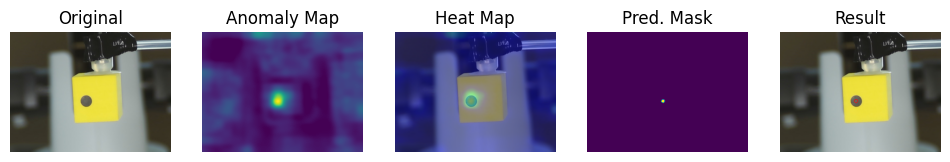

In [16]:
# create figure
fig = plt.figure(figsize=(12, 10))

# setting values to rows and column variables
rows = 1
columns = 5

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(predictions.image)
plt.axis("off")
plt.title("Original")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(predictions.anomaly_map)
plt.axis("off")
plt.title("Anomaly Map")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(predictions.heat_map)
plt.axis("off")
plt.title("Heat Map")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(predictions.pred_mask)
plt.axis("off")
plt.title("Pred. Mask")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 5)

# showing image
plt.imshow(predictions.segmentations)
plt.axis("off")
plt.title("Result")

print(predictions.pred_score, predictions.pred_label)